In [1]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import tensorflow as tf
#import tensorflow.keras.backend as K
#from sklearn.metrics import confusion_matrix
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
#from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D
#from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D
from keras.layers import MaxPool2D

In [2]:
np.random.seed(0)

In [3]:
!wget https://www.kaggle.com/datasets/harshart/balanced-plant-dataset/download?datasetVersionNumber=1
!unzip /content/archive.zip?dl=0

--2023-09-02 14:31:41--  https://www.kaggle.com/datasets/harshart/balanced-plant-dataset/download?datasetVersionNumber=1
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-09-02 14:31:41 ERROR 404: Not Found.

unzip:  cannot find or open /content/archive.zip?dl=0, /content/archive.zip?dl=0.zip or /content/archive.zip?dl=0.ZIP.

No zipfiles found.


In [4]:
from google.colab import files #add .json file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [6]:
import zipfile
import os
from kaggle.cli import main
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [7]:
!kaggle datasets download -d harshart/balanced-plant-dataset

 97% 548M/566M [00:04<00:00, 146MB/s]
100% 566M/566M [00:04<00:00, 130MB/s]


In [8]:
zip_ref = zipfile.ZipFile('balanced-plant-dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

Strawberry Training and Validation

In [9]:
data_dir = r"/tmp/Dataset alpha"
train_dir = data_dir + "/Training/strawberry"
valid_dir = data_dir + "/Valid/strawberry"
diseases = os.listdir('/tmp/Dataset alpha/Training/')
#healthe = os.listdir('/tmp/Dataset alpha/Training/healthy')

In [10]:
train_healthy_strawberry_dir = '/tmp/Dataset alpha/Training/strawberry/Strawberry___healthy'
train_disease_dir = '/tmp/Dataset alpha/Training/strawberry/Strawberry___Leaf_scorch'

valid_healthy_strawberry_dir = '/tmp/Dataset alpha/Valid/strawberry/Strawberry___healthy'
valid_disease_dir = '/tmp/Dataset alpha/Valid/strawberry/Strawberry___Leaf_scorch'
#valid_main = '/tmp/Dataset alpha/Valid/healthy/Strawberry___healthy' + '/tmp/Dataset alpha/valid/disease/Strawberry___Leaf_scorch'

In [1]:
%%time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=True)

### How mean values are estimated? 
datagen.mean = [123.68, 116.779, 103.939]


train_it = datagen.flow_from_directory(batch_size = 32,
                                                     directory = train_dir,
                                                     shuffle= True,
                                                     target_size = (128 , 128),
                                                    class_mode  = "categorical")

valid_it = datagen.flow_from_directory(batch_size = 32,
                                                     directory = valid_dir,
                                                     shuffle= True,
                                                     target_size = (128, 128),
                                                    class_mode  = "categorical")

# As per EDA Strawberry has only (1824+1774) training and  (456+444) validation images. 
# Without any data augmentation why more iamges are detected?

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:585: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [12]:
target_names=train_it.class_indices
print(target_names);
print('len(target_names)',len(target_names))

{'Strawberry___Leaf_scorch': 0, 'Strawberry___healthy': 1}

len(target_names 2


VGG16 with flatten layer

In [ ]:
# VG16 with flatten layer
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(128, 128, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(2, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [ ]:
model = define_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
%%time
epochsteps=len(train_it);epochs =10;valsteps=len(valid_it)
# fit model
history = model.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=10, verbose=1)
_, acc = model.evaluate(valid_it, steps=75, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/10
225/225 [==============================] - 21s 85ms/step - loss: 0.7066 - accuracy: 0.9764 - val_loss: 0.0122 - val_accuracy: 0.9967
Epoch 2/10
225/225 [==============================] - 17s 74ms/step - loss: 7.7001e-05 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 0.9967
Epoch 3/10
225/225 [==============================] - 16s 69ms/step - loss: 1.3974e-05 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 0.9944
Epoch 4/10
225/225 [==============================] - 15s 68ms/step - loss: 5.4431e-06 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 0.9944
Epoch 5/10
225/225 [==============================] - 15s 69ms/step - loss: 4.4546e-06 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9944
Epoch 6/10
225/225 [==============================] - 16s 71ms/step - loss: 3.8544e-06 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9944
Epoch 7/10
225/225 [==============================] - 15s 68ms/step - loss: 3.3548e-06 - accuracy: 1.0000 - val_loss

75/75 [==============================] - 3s 41ms/step - loss: 0.0118 - accuracy: 0.9944
accuracy 99.44444298744202
CPU times: user 2min 55s, sys: 7.03 s, total: 3min 2s
Wall time: 2min 54s


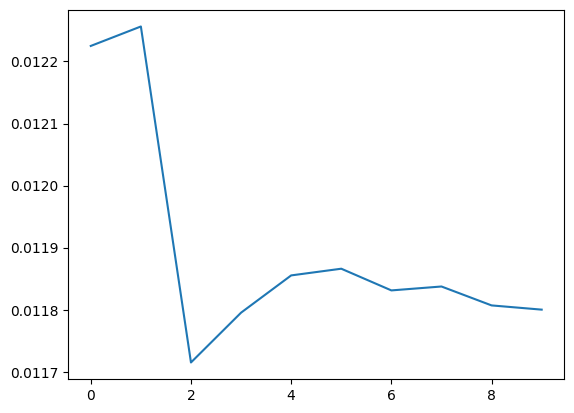

In [ ]:
# Observe both losses together
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.show()

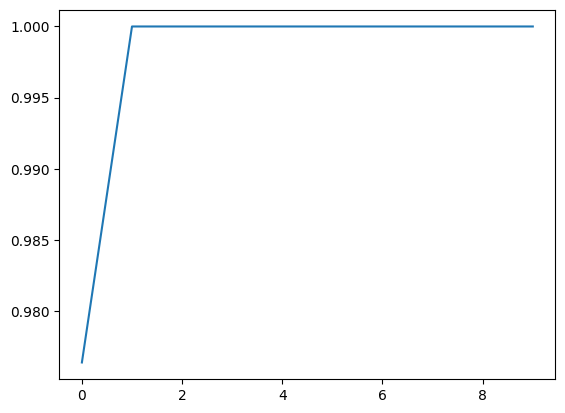

In [ ]:
plt.plot(history.history['accuracy'])

In [ ]:
plot_accuracies(history)

TypeError: ignored

Cherry Training and validation

In [ ]:
data_dir = r"/tmp/Dataset alpha"
train_cherry_dir = data_dir + "/Training/cherry"
valid_cherry_dir = data_dir + "/Valid/cherry"
diseases = os.listdir('/tmp/Dataset alpha/Training/')
#healthe = os.listdir('/tmp/Dataset alpha/Training/healthy')

In [ ]:
train_healthy_cherry_dir = '/tmp/Dataset alpha/Training/cherry/Cherry_(including_sour)___healthy'
#/tmp/Dataset alpha/Training/cherry/Cherry_(including_sour)___Powdery_mildew
#/tmp/Dataset alpha/Training/cherry/Cherry_(including_sour)___healthy
train_disease_cherry_dir = '/tmp/Dataset alpha/Training/cherry/Cherry_(including_sour)___healthy'

valid_healthy_cherry_dir = '/tmp/Dataset alpha/Valid/cherry/Cherry_(including_sour)___healthy'
valid_disease_cherry_dir = '/tmp/Dataset alpha/Valid/Cherry_(including_sour)___Powdery_mildew'
#valid_main = '/tmp/Dataset alpha/Valid/healthy/Strawberry___healthy' + '/tmp/Dataset alpha/valid/disease/Strawberry___Leaf_scorch'

In [ ]:
%%time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=True)

### How mean values are estimated? 
datagen.mean = [123.68, 116.779, 103.939]
train_it = datagen.flow_from_directory(batch_size = 32,
                                                     directory = train_cherry_dir,
                                                     shuffle= True,
                                                     target_size = (128 , 128),
                                                    class_mode  = "categorical")

valid_it = datagen.flow_from_directory(batch_size = 32,
                                                     directory = valid_cherry_dir,
                                                     shuffle= True,
                                                     target_size = (128, 128),
                                                    class_mode  = "categorical")

Found 7018 images belonging to 2 classes.
Found 1754 images belonging to 2 classes.
CPU times: user 232 ms, sys: 12.1 ms, total: 244 ms
Wall time: 258 ms


In [ ]:
# As per EDA cherry has only (18226+1683) training and  (456+421) validation images. 
# Without any data augmentation why more iamges are detected?

In [ ]:
target_names=train_it.class_indices
print(target_names);print()
print('len(target_names',len(target_names))

{'Cherry_(including_sour)___Powdery_mildew': 0, 'Cherry_(including_sour)___healthy': 1}

len(target_names 2


VGG16 with flatten

In [ ]:
# vgg16 with flatten
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(128, 128, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(2, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [ ]:
model = define_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
%%time
epochsteps=len(train_it);epochs =10;valsteps=len(valid_it)
# fit model
history = model.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=10, verbose=1)
_, acc = model.evaluate(valid_it, steps=valsteps, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/10
220/220 [==============================] - 28s 79ms/step - loss: 0.3726 - accuracy: 0.9845 - val_loss: 0.0143 - val_accuracy: 0.9989
Epoch 2/10
220/220 [==============================] - 15s 68ms/step - loss: 2.2038e-05 - accuracy: 1.0000 - val_loss: 0.0127 - val_accuracy: 0.9989
Epoch 3/10
220/220 [==============================] - 15s 67ms/step - loss: 3.9255e-07 - accuracy: 1.0000 - val_loss: 0.0124 - val_accuracy: 0.9989
Epoch 4/10
220/220 [==============================] - 15s 69ms/step - loss: 2.3582e-07 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 0.9989
Epoch 5/10
220/220 [==============================] - 14s 65ms/step - loss: 1.6502e-07 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9989
Epoch 6/10
220/220 [==============================] - 17s 78ms/step - loss: 1.2504e-07 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 0.9989
Epoch 7/10
220/220 [==============================] - 15s 66ms/step - loss: 9.8141e-08 - accuracy: 1.0000 - val_loss

75/75 [==============================] - 3s 38ms/step - loss: 0.0111 - accuracy: 0.9989
accuracy 99.88597631454468
CPU times: user 2min 47s, sys: 8.69 s, total: 2min 56s
Wall time: 3min 2s


VGG16 with averagepooling

In [ ]:
from keras.layers.pooling.average_pooling2d import AveragePooling2D
# vgg16 with avgpooling
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_modelavg():
    # load model
    model = VGG16(include_top=False, input_shape=(128, 128, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    #flat1 = Flatten()(model.layers[-1].output)
    avgpool1=AveragePooling2D(strides=2)(model.layers[-1].output)
    flat1 = Flatten()(avgpool1)

    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(2, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [ ]:
modelavg = define_modelavg()
modelavg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelavg.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
%%time
epochsteps=len(train_it);epochs =10;valsteps=len(valid_it)
# fit model
history = modelavg.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=10, verbose=1)
_, acc = modelavg.evaluate(valid_it, steps=valsteps, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/10
220/220 [==============================] - 17s 71ms/step - loss: 0.1303 - accuracy: 0.9859 - val_loss: 0.0217 - val_accuracy: 0.9966
Epoch 2/10
220/220 [==============================] - 15s 68ms/step - loss: 3.0980e-05 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 0.9966
Epoch 3/10
220/220 [==============================] - 16s 72ms/step - loss: 2.2186e-06 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 0.9966
Epoch 4/10
220/220 [==============================] - 15s 69ms/step - loss: 1.7480e-06 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9966
Epoch 5/10
220/220 [==============================] - 15s 69ms/step - loss: 1.4572e-06 - accuracy: 1.0000 - val_loss: 0.0225 - val_accuracy: 0.9966
Epoch 6/10
220/220 [==============================] - 17s 77ms/step - loss: 1.2406e-06 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 0.9966
Epoch 7/10
220/220 [==============================] - 15s 69ms/step - loss: 1.0751e-06 - accuracy: 1.0000 - val_loss

75/75 [==============================] - 3s 40ms/step - loss: 0.0220 - accuracy: 0.9966
accuracy 99.65792298316956
CPU times: user 2min 46s, sys: 8.65 s, total: 2min 55s
Wall time: 3min 2s


VGG16 with GlobalAveragePooling

In [ ]:

from keras.layers.pooling.global_average_pooling2d import GlobalAveragePooling2D
# vgg16 with globalavgpooling
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_modelavg():
    # load model
    model = VGG16(include_top=False, input_shape=(128, 128, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    #flat1 = Flatten()(model.layers[-1].output)
    avgpool1=GlobalAveragePooling2D()(model.layers[-1].output)
    #flat1 = Flatten()(avgpool1)

    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(avgpool1)
    output = Dense(2, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [ ]:
modelavg = define_modelavg()
modelavg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelavg.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
%%time
epochsteps=len(train_it);epochs =10;valsteps=len(valid_it)
# fit model
history = modelavg.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=10, verbose=1)
_, acc = modelavg.evaluate(valid_it, steps=75, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/10
220/220 [==============================] - 16s 67ms/step - loss: 0.0716 - accuracy: 0.9850 - val_loss: 0.0134 - val_accuracy: 0.9966
Epoch 2/10
220/220 [==============================] - 15s 68ms/step - loss: 2.3596e-04 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 0.9966
Epoch 3/10
220/220 [==============================] - 15s 67ms/step - loss: 9.5601e-05 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 0.9966
Epoch 4/10
220/220 [==============================] - 15s 66ms/step - loss: 4.9292e-05 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 0.9966
Epoch 5/10
220/220 [==============================] - 15s 69ms/step - loss: 2.7298e-05 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 0.9977
Epoch 6/10
220/220 [==============================] - 19s 84ms/step - loss: 1.8848e-05 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 0.9977
Epoch 7/10
220/220 [==============================] - 15s 66ms/step - loss: 1.3442e-05 - accuracy: 1.0000 - val_loss

75/75 [==============================] - 3s 40ms/step - loss: 0.0103 - accuracy: 0.9977
accuracy 99.77195262908936
CPU times: user 2min 43s, sys: 7.79 s, total: 2min 50s
Wall time: 2min 57s


Trying Different Dense layer

In [ ]:
# define cnn model
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(128, 128, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(64, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(2, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [ ]:
model = define_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
%%time
epochsteps=len(train_it);epochs =10;valsteps=len(valid_it)
# fit model
history = model.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=10, verbose=1)
_, acc = model.evaluate(valid_it, steps=75, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/10
225/225 [==============================] - 32s 92ms/step - loss: 0.2920 - accuracy: 0.9778 - val_loss: 0.0162 - val_accuracy: 0.9933
Epoch 2/10
225/225 [==============================] - 17s 75ms/step - loss: 5.2898e-04 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 0.9956
Epoch 3/10
225/225 [==============================] - 16s 72ms/step - loss: 7.5968e-05 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.9956
Epoch 4/10
225/225 [==============================] - 19s 83ms/step - loss: 3.7770e-05 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 0.9956
Epoch 5/10
225/225 [==============================] - 16s 72ms/step - loss: 2.4612e-05 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.9956
Epoch 6/10
225/225 [==============================] - 17s 76ms/step - loss: 1.8054e-05 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 0.9956
Epoch 7/10
225/225 [==============================] - 17s 74ms/step - loss: 1.3919e-05 - accuracy: 1.0000 - val_loss

75/75 [==============================] - 3s 42ms/step - loss: 0.0138 - accuracy: 0.9944
accuracy 99.44444298744202
CPU times: user 3min 5s, sys: 10.2 s, total: 3min 16s
Wall time: 3min 32s


In [ ]:
# define cnn model
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(128, 128, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(32, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(2, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [ ]:
model = define_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
%%time
epochsteps=len(train_it);epochs =10;valsteps=len(valid_it)
# fit model
history = model.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=10, verbose=1)
_, acc = model.evaluate(valid_it, steps=75, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/10
225/225 [==============================] - 18s 73ms/step - loss: 0.1948 - accuracy: 0.9860 - val_loss: 0.0144 - val_accuracy: 0.9967
Epoch 2/10
225/225 [==============================] - 19s 83ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0146 - val_accuracy: 0.9956
Epoch 3/10
225/225 [==============================] - 16s 73ms/step - loss: 2.8542e-04 - accuracy: 0.9997 - val_loss: 0.0153 - val_accuracy: 0.9978
Epoch 4/10
225/225 [==============================] - 17s 74ms/step - loss: 2.4161e-05 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9978
Epoch 5/10
225/225 [==============================] - 16s 73ms/step - loss: 5.8514e-07 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9978
Epoch 6/10
225/225 [==============================] - 16s 70ms/step - loss: 5.2535e-07 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9978
Epoch 7/10
225/225 [==============================] - 18s 81ms/step - loss: 4.7633e-07 - accuracy: 1.0000 - val_loss: 0.

75/75 [==============================] - 3s 41ms/step - loss: 0.0122 - accuracy: 0.9978
accuracy 99.77777600288391
CPU times: user 2min 59s, sys: 9.01 s, total: 3min 8s
Wall time: 3min 8s


In [ ]:
# define cnn model
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(128, 128, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(16, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(2, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [ ]:
model = define_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
%%time
epochsteps=len(train_it);epochs =10;valsteps=len(valid_it)
# fit model
history = model.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=10, verbose=1)
_, acc = model.evaluate(valid_it, steps=75, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/10
225/225 [==============================] - 17s 72ms/step - loss: 0.1308 - accuracy: 0.9803 - val_loss: 0.0090 - val_accuracy: 0.9944
Epoch 2/10
225/225 [==============================] - 17s 75ms/step - loss: 5.7256e-04 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 0.9978
Epoch 3/10
225/225 [==============================] - 16s 73ms/step - loss: 2.4107e-04 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9989
Epoch 4/10
225/225 [==============================] - 16s 72ms/step - loss: 1.4748e-04 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9989
Epoch 5/10
225/225 [==============================] - 18s 81ms/step - loss: 9.7704e-05 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 0.9989
Epoch 6/10
225/225 [==============================] - 16s 73ms/step - loss: 6.8778e-05 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9978
Epoch 7/10
225/225 [==============================] - 17s 74ms/step - loss: 5.0877e-05 - accuracy: 1.0000 - val_loss

75/75 [==============================] - 3s 43ms/step - loss: 0.0053 - accuracy: 0.9978
accuracy 99.77777600288391
CPU times: user 2min 59s, sys: 8.98 s, total: 3min 8s
Wall time: 3min


In [ ]:
# define cnn model
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(128, 128, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(8, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(2, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [ ]:
model = define_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
%%time
epochsteps=len(train_it);epochs =10;valsteps=len(valid_it)
# fit model
history = model.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=10, verbose=1)
_, acc = model.evaluate(valid_it, steps=75, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/10
225/225 [==============================] - 18s 76ms/step - loss: 0.2606 - accuracy: 0.9797 - val_loss: 0.0113 - val_accuracy: 0.9978
Epoch 2/10
225/225 [==============================] - 16s 72ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0092 - val_accuracy: 0.9967
Epoch 3/10
225/225 [==============================] - 17s 76ms/step - loss: 4.8108e-05 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9967
Epoch 4/10
225/225 [==============================] - 18s 81ms/step - loss: 1.1672e-05 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 0.9967
Epoch 5/10
225/225 [==============================] - 18s 82ms/step - loss: 9.4292e-06 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 0.9967
Epoch 6/10
225/225 [==============================] - 16s 73ms/step - loss: 8.0141e-06 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 0.9967
Epoch 7/10
225/225 [==============================] - 21s 91ms/step - loss: 7.0599e-06 - accuracy: 1.0000 - val_loss: 0.

75/75 [==============================] - 3s 42ms/step - loss: 0.0098 - accuracy: 0.9967
accuracy 99.6666669845581
CPU times: user 3min, sys: 9.14 s, total: 3min 10s
Wall time: 3min 33s


In [ ]:
from keras.layers import MaxPool2D
from keras.layers import IntegerLookup

In [ ]:
#model 1
model1 = models.Sequential()
model1 = Sequential()
#model1.add(Conv2D(filters=4,kernel_size=(3,3),padding="same", activation="relu", input_shape=(224,224,3)))
model1.add(Conv2D(filters=16,kernel_size=(3,3),padding="same", activation="relu", input_shape=(128,128,3)))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model1.add(Dropout(0.4))

#model1.add(Conv2D(filters=8, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model1.add(Dropout(0.5))

flat1 = Flatten()(model1.layers[-1].output)
class1 = Dense(16, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(2, activation='softmax')(class1)
#model1 = Model(inputs=model1.inputs, outputs=output)



In [ ]:
#model1 = define_model()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12_input (InputLayer  [(None, 128, 128, 3)]    0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                           

In [ ]:
%%time
#model 1 trained on strawberry dataset
epochsteps=len(train_it);epochs =5;valsteps=len(valid_it)
# fit model
history = model1.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=5, verbose=1)
_, acc = model1.evaluate(valid_it, steps=valsteps, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/5
225/225 [==============================] - 15s 68ms/step - loss: 0.3076 - accuracy: 0.9439 - val_loss: 0.0517 - val_accuracy: 0.9911
Epoch 2/5
225/225 [==============================] - 14s 63ms/step - loss: 0.0280 - accuracy: 0.9936 - val_loss: 0.0273 - val_accuracy: 0.9922
Epoch 3/5
225/225 [==============================] - 13s 60ms/step - loss: 0.0253 - accuracy: 0.9936 - val_loss: 0.0249 - val_accuracy: 0.9933
Epoch 4/5
225/225 [==============================] - 14s 62ms/step - loss: 0.0095 - accuracy: 0.9982 - val_loss: 0.0171 - val_accuracy: 0.9944
Epoch 5/5
57/57 [==============================] - 3s 46ms/step - loss: 0.0590 - accuracy: 0.9856
accuracy 98.55555295944214
CPU times: user 1min 20s, sys: 2.75 s, total: 1min 23s
Wall time: 1min 38s


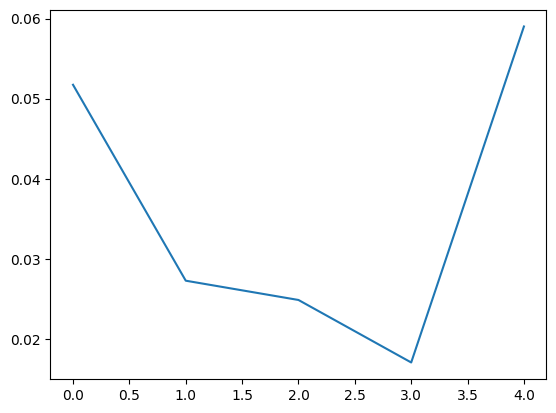

In [ ]:
#Observe both losses together
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

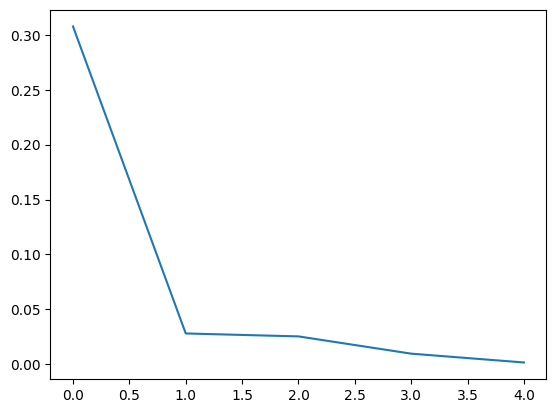

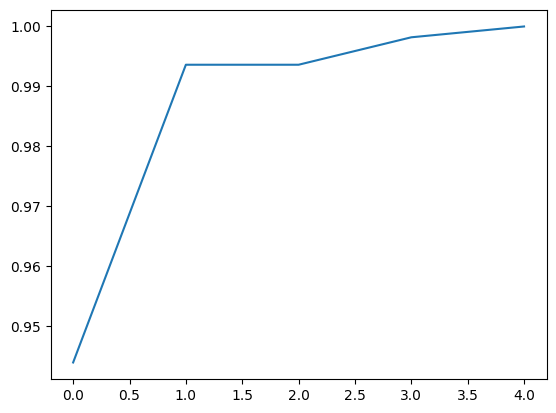

In [ ]:
plt.plot(history.history['accuracy'])

In [ ]:
%%time
# Following code further trains strawberry model on cherry dataset. 
# To train fresh model, it mu be compiled again before applying fit commdand.

#model 1 trained on cherry dataset
epochsteps=len(train_it);epochs =5;valsteps=len(valid_it)
# fit model
history = model1.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=5, verbose=1)
_, acc = model1.evaluate(valid_it, steps=valsteps, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/5
220/220 [==============================] - 13s 58ms/step - loss: 1.0536e-05 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 0.9977
Epoch 2/5
220/220 [==============================] - 13s 59ms/step - loss: 9.1546e-06 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9977
Epoch 3/5
220/220 [==============================] - 13s 59ms/step - loss: 7.8309e-06 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9989
Epoch 4/5
220/220 [==============================] - 13s 60ms/step - loss: 6.7001e-06 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9977
Epoch 5/5
55/55 [==============================] - 2s 41ms/step - loss: 0.0060 - accuracy: 0.9989
accuracy 99.88597631454468
CPU times: user 1min 14s, sys: 2.75 s, total: 1min 17s
Wall time: 1min 7s


In [ ]:
print(valsteps)

55


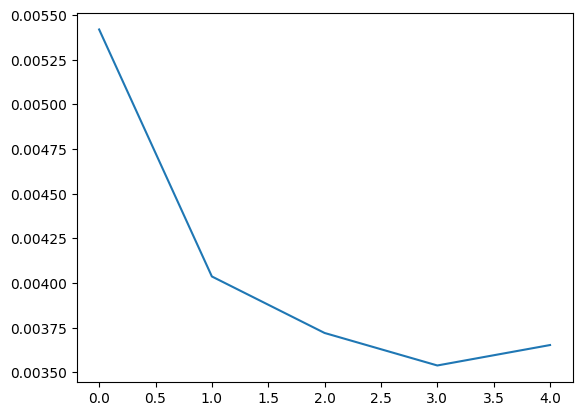

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

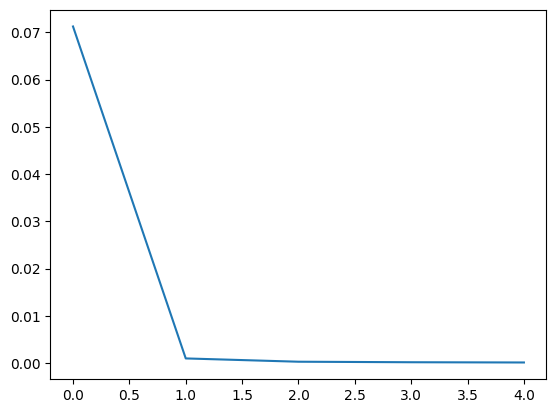

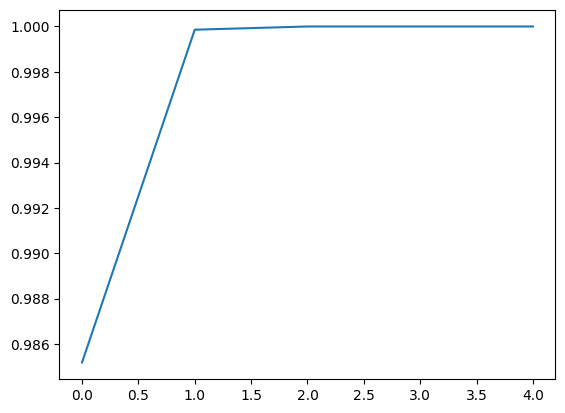

In [ ]:
plt.plot(history.history['accuracy'])

Training and Validation for peach

In [ ]:
data_dir = r"/tmp/Dataset alpha"
train_peach_dir = data_dir + "/Training/peach"
valid_peach_dir = data_dir + "/Valid/peach"
diseases = os.listdir('/tmp/Dataset alpha/Training/')
#healthe = os.listdir('/tmp/Dataset alpha/Training/healthy')

In [ ]:
train_healthy_peach_dir = '/tmp/Dataset alpha/Training/peach/Peach___healthy'
train_disease_peach_dir = '/tmp/Dataset alpha/Training/peach/Peach___Bacterial_spot'

valid_healthy_peach_dir = '/tmp/Dataset alpha/Valid/peach/Peach___healthy'
valid_disease_peach_dir = '/tmp/Dataset alpha/Valid/peach/Peach___Bacterial_spot'

In [2]:
%%time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=True)

# Mean?
datagen.mean = [123.68, 116.779, 103.939]
train_it = datagen.flow_from_directory(batch_size = 32,
                                                     directory = train_peach_dir,
                                                     shuffle= True,
                                                     target_size = (128 , 128),
                                                    class_mode  = "categorical")

valid_it = datagen.flow_from_directory(batch_size = 32,
                                                     directory = valid_peach_dir,
                                                     shuffle= True,
                                                     target_size = (128, 128),
                                                    class_mode  = "categorical")

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:585: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# Number of images is larger than EDA report. Why? How?

In [ ]:
target_names=train_it.class_indices
print(target_names);print()
print('len(target_names)= ',len(target_names))

{'Peach___Bacterial_spot': 0, 'Peach___healthy': 1}

len(target_names)=  2


In [ ]:
# define cnn model
from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(128, 128, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(2, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [ ]:
model = define_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
%%time
epochsteps=len(train_it);epochs =10;valsteps=len(valid_it)
# fit model
history = model.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=10, verbose=1)
_, acc = model.evaluate(valid_it, steps=75, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/10
223/223 [==============================] - 30s 85ms/step - loss: 0.4319 - accuracy: 0.9670 - val_loss: 0.0494 - val_accuracy: 0.9921
Epoch 2/10
223/223 [==============================] - 15s 65ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0403 - val_accuracy: 0.9910
Epoch 3/10
223/223 [==============================] - 16s 70ms/step - loss: 1.8945e-04 - accuracy: 1.0000 - val_loss: 0.0399 - val_accuracy: 0.9921
Epoch 4/10
223/223 [==============================] - 17s 77ms/step - loss: 8.8555e-05 - accuracy: 1.0000 - val_loss: 0.0388 - val_accuracy: 0.9933
Epoch 5/10
223/223 [==============================] - 15s 65ms/step - loss: 5.6074e-05 - accuracy: 1.0000 - val_loss: 0.0392 - val_accuracy: 0.9933
Epoch 6/10
223/223 [==============================] - 15s 66ms/step - loss: 4.0333e-05 - accuracy: 1.0000 - val_loss: 0.0397 - val_accuracy: 0.9933
Epoch 7/10
223/223 [==============================] - 14s 65ms/step - loss: 3.0210e-05 - accuracy: 1.0000 - val_loss: 0.

75/75 [==============================] - 4s 48ms/step - loss: 0.0414 - accuracy: 0.9933
accuracy 99.32659864425659
CPU times: user 2min 50s, sys: 8.24 s, total: 2min 58s
Wall time: 2min 56s


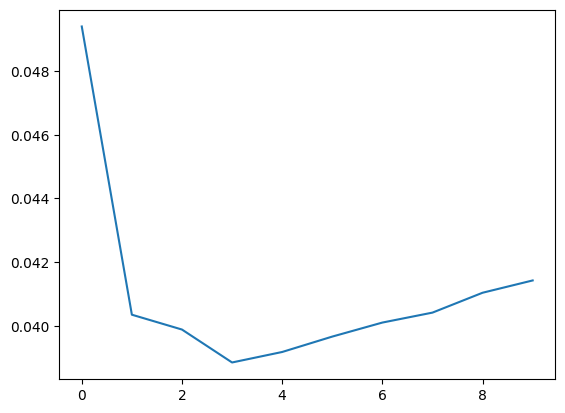

In [ ]:
plt.plot(history.history['val_loss'])

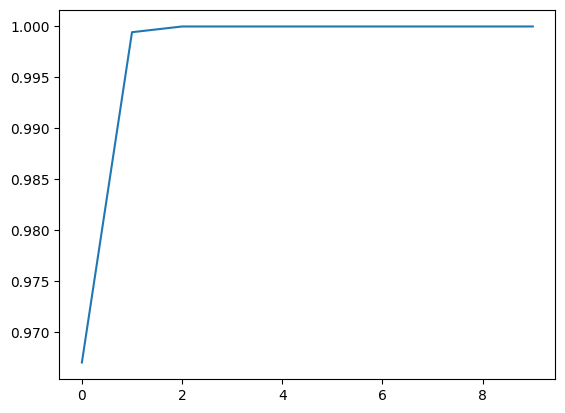

In [ ]:
plt.plot(history.history['accuracy'])

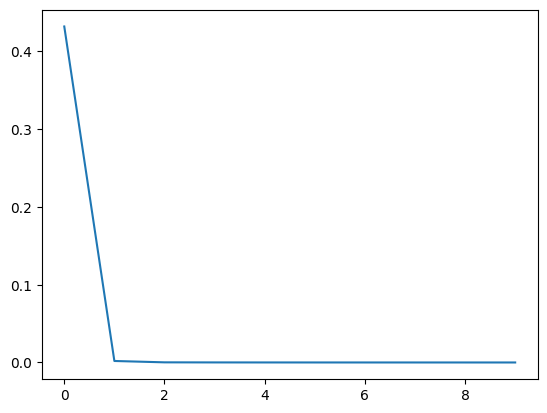

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
%%time
#model 1 trained on peach dataset
epochsteps=len(train_it);epochs =5;valsteps=len(valid_it)
# fit model
history = model1.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=5, verbose=1)
_, acc = model1.evaluate(valid_it, steps=valsteps, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/5
223/223 [==============================] - 13s 56ms/step - loss: 3.4623e-05 - accuracy: 1.0000 - val_loss: 0.0671 - val_accuracy: 0.9865
Epoch 2/5
223/223 [==============================] - 12s 55ms/step - loss: 2.6317e-05 - accuracy: 1.0000 - val_loss: 0.0683 - val_accuracy: 0.9865
Epoch 3/5
223/223 [==============================] - 12s 55ms/step - loss: 2.0493e-05 - accuracy: 1.0000 - val_loss: 0.0679 - val_accuracy: 0.9877
Epoch 4/5
223/223 [==============================] - 13s 58ms/step - loss: 1.6143e-05 - accuracy: 1.0000 - val_loss: 0.0689 - val_accuracy: 0.9877
Epoch 5/5
56/56 [==============================] - 3s 51ms/step - loss: 0.0692 - accuracy: 0.9877
accuracy 98.76543283462524
CPU times: user 1min 12s, sys: 2.38 s, total: 1min 14s
Wall time: 1min 22s


# **Bell Pepper**

In [ ]:
train_bp_dir = data_dir + "/Training/bell-pepper"
valid_bp_dir = data_dir + "/Valid/bell-pepper"
diseases = os.listdir('/tmp/Dataset alpha/Training/')
#healthe = os.listdir('/tmp/Dataset alpha/Training/healthy')

In [ ]:
train_healthy_bp_dir = '/tmp/Dataset alpha/Training/bell-pepper/Bell-Pepper___healthy'
train_disease_bp_dir = '/tmp/Dataset alpha/Training/bell-pepper/Bell-Pepper___Bacterial_spot'

valid_healthy_bp_dir = '/tmp/Dataset alpha/Valid/bell-pepper/Bell-Pepper___healthy'
valid_disease_bp_dir = '/tmp/Dataset alpha/Valid/bell-pepper/Bell-Pepper___Bacterial_spot'

vgg16 model

In [ ]:
#flatten

from keras.applications.vgg16 import VGG16
from keras.models import Model
def define_model():
    # load model
    model_bp = VGG16(include_top=False, input_shape=(128, 128, 3))
    # mark loaded layers as not trainable
    for layer in model_bp.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model_bp.layers[-1].output)
    class1 = Dense(6, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(2, activation='softmax')(class1)
    # define new model
    model_bp = Model(inputs=model_bp.inputs, outputs=output)
    return model_bp

In [ ]:
model_bp = define_model()
model_bp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_bp.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
epochsteps=len(train_it);epochs=10;valsteps=len(valid_it)
# fit model
history = model_bp.fit(train_it, steps_per_epoch=epochsteps,
                    validation_data=valid_it, validation_steps=valsteps, epochs=10, verbose=1)
_, acc = model_bp.evaluate(valid_it, steps=valsteps, verbose=1)
print('accuracy',acc * 100.0)

Epoch 1/10
225/225 [==============================] - 15s 69ms/step - loss: 1.1899e-05 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/10
225/225 [==============================] - 15s 68ms/step - loss: 9.7492e-06 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/10
225/225 [==============================] - 16s 71ms/step - loss: 8.0834e-06 - accuracy: 1.0000 - val_loss: 9.9799e-04 - val_accuracy: 1.0000
Epoch 4/10
 68/225 [========>.....................] - ETA: 10s - loss: 6.2332e-06 - accuracy: 1.0000